<a href="https://colab.research.google.com/github/SurweeshSP/GDSC/blob/main/Protein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'test' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname test_a5e17
sequence PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK
length 59


In [ ]:
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
CPU times: user 223 ms, sys: 36.8 ms, total: 260 ms
Wall time: 52.8 s


In [ ]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

2025-03-28 01:31:29,464 WARNING: no GPU detected, will be using CPU
2025-03-28 01:31:38,199 Found 5 citations for tools or databases
2025-03-28 01:31:38,200 Query 1/1: test_a5e17 (length 59)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:00 remaining: 00:00]


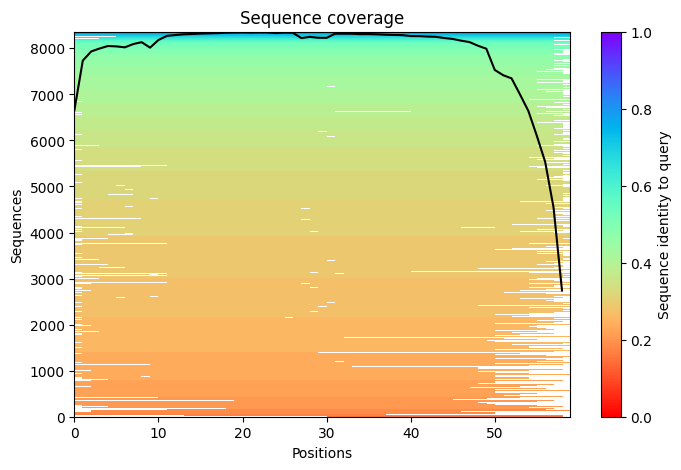

2025-03-28 01:31:40,170 Setting max_seq=512, max_extra_seq=5120
2025-03-28 01:42:35,756 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=96.6 pTM=0.756
2025-03-28 01:52:31,325 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=96.6 pTM=0.759 tol=0.287
2025-03-28 02:02:30,065 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=96.3 pTM=0.755 tol=0.0334
2025-03-28 02:12:25,769 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=96 pTM=0.755 tol=0.0382
2025-03-28 02:12:25,772 alphafold2_ptm_model_1_seed_000 took 2429.9s (3 recycles)


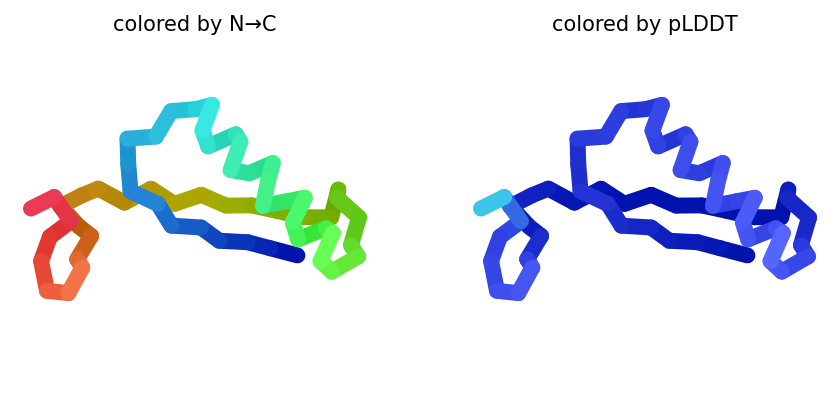

2025-03-28 02:22:20,549 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=97 pTM=0.761
2025-03-28 02:32:17,311 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=97 pTM=0.766 tol=0.37
2025-03-28 02:42:14,606 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=96.9 pTM=0.766 tol=0.145
2025-03-28 02:52:12,497 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=96.9 pTM=0.768 tol=0.0679
2025-03-28 02:52:12,500 alphafold2_ptm_model_2_seed_000 took 2386.5s (3 recycles)


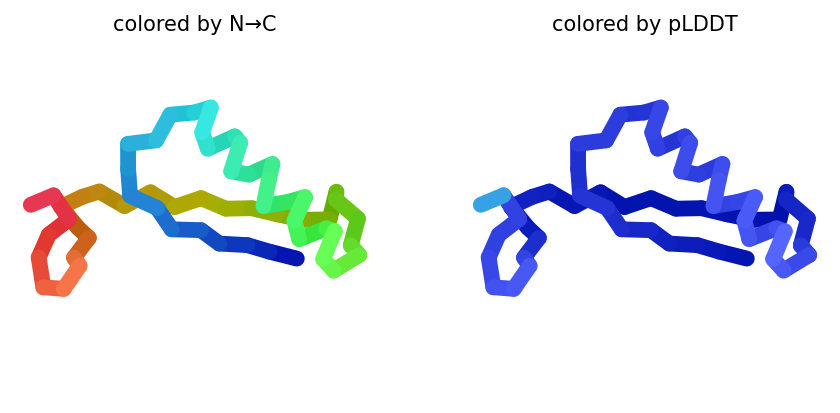

2025-03-28 03:01:54,686 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=97.2 pTM=0.776
2025-03-28 03:11:34,334 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=97.4 pTM=0.783 tol=0.285
2025-03-28 03:21:16,073 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=97.4 pTM=0.781 tol=0.13
2025-03-28 03:30:57,435 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=97.4 pTM=0.784 tol=0.0487
2025-03-28 03:30:57,436 alphafold2_ptm_model_3_seed_000 took 2324.8s (3 recycles)


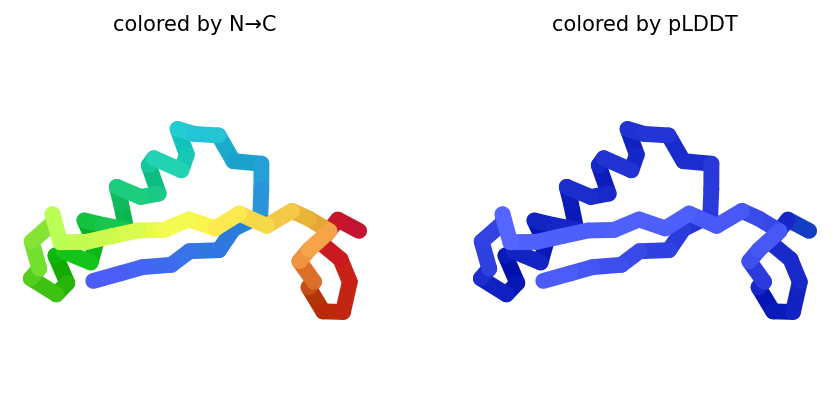

2025-03-28 03:40:38,898 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=97.4 pTM=0.774
2025-03-28 03:50:17,479 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=97.4 pTM=0.781 tol=0.319
2025-03-28 03:59:53,613 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=97.2 pTM=0.777 tol=0.101
2025-03-28 04:09:49,914 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=97 pTM=0.778 tol=0.0329
2025-03-28 04:09:49,916 alphafold2_ptm_model_4_seed_000 took 2332.3s (3 recycles)


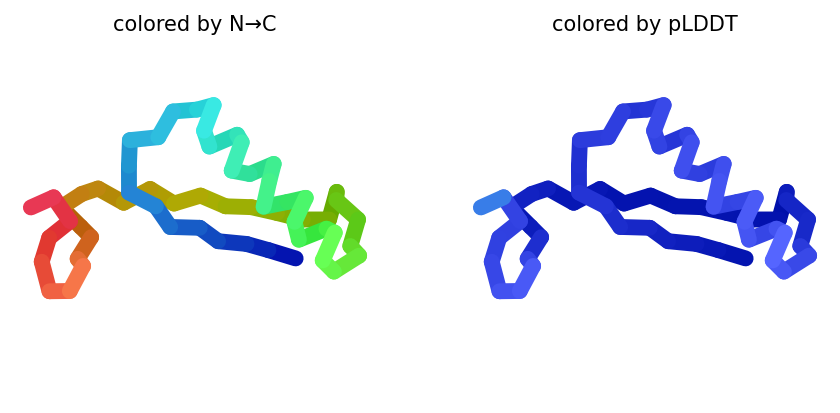

2025-03-28 04:19:51,491 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=97.4 pTM=0.784
2025-03-28 04:29:46,858 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=96.9 pTM=0.784 tol=0.264
2025-03-28 04:39:48,992 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=96.1 pTM=0.774 tol=0.204
2025-03-28 04:49:44,468 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=96.2 pTM=0.779 tol=0.101
2025-03-28 04:49:44,470 alphafold2_ptm_model_5_seed_000 took 2394.4s (3 recycles)


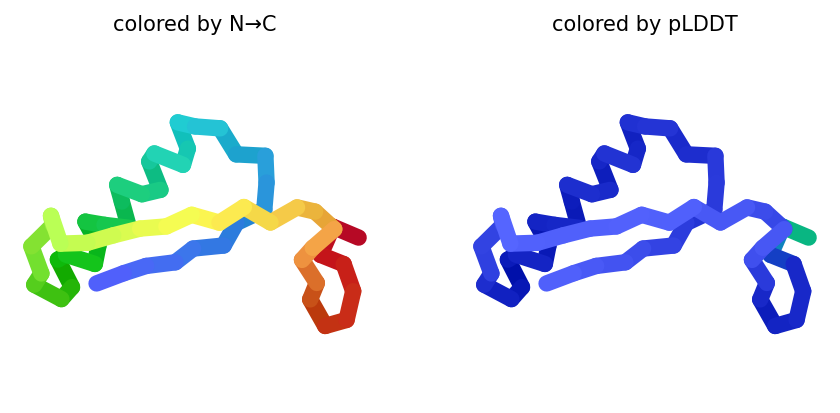

2025-03-28 04:49:44,674 reranking models by 'plddt' metric
2025-03-28 04:49:44,675 rank_001_alphafold2_ptm_model_3_seed_000 pLDDT=97.4 pTM=0.784
2025-03-28 04:49:44,676 rank_002_alphafold2_ptm_model_4_seed_000 pLDDT=97 pTM=0.778
2025-03-28 04:49:44,676 rank_003_alphafold2_ptm_model_2_seed_000 pLDDT=96.9 pTM=0.768
2025-03-28 04:49:44,676 rank_004_alphafold2_ptm_model_5_seed_000 pLDDT=96.2 pTM=0.779
2025-03-28 04:49:44,676 rank_005_alphafold2_ptm_model_1_seed_000 pLDDT=96 pTM=0.755
2025-03-28 04:49:46,986 Done


0

In [4]:
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = False #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

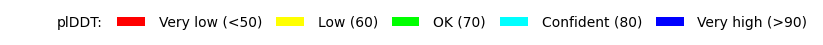

In [5]:
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()


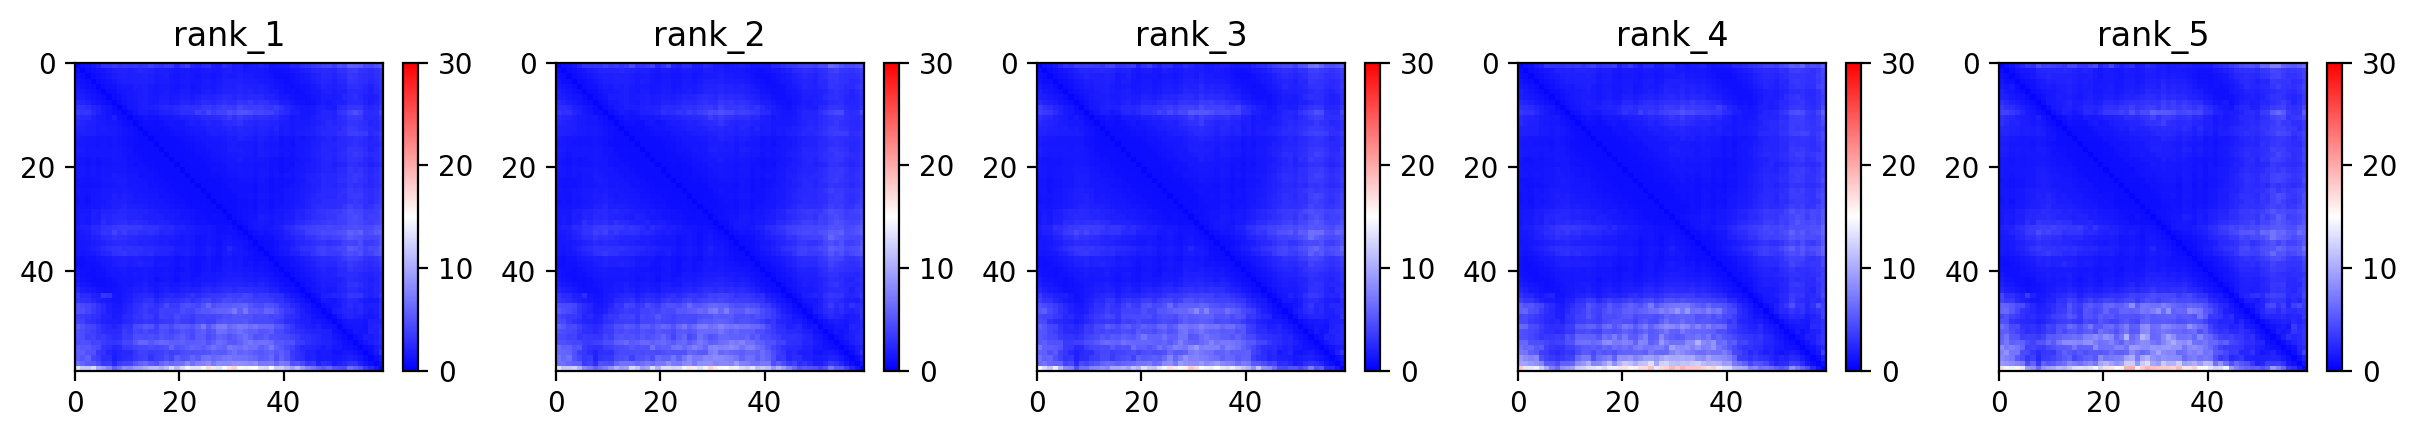
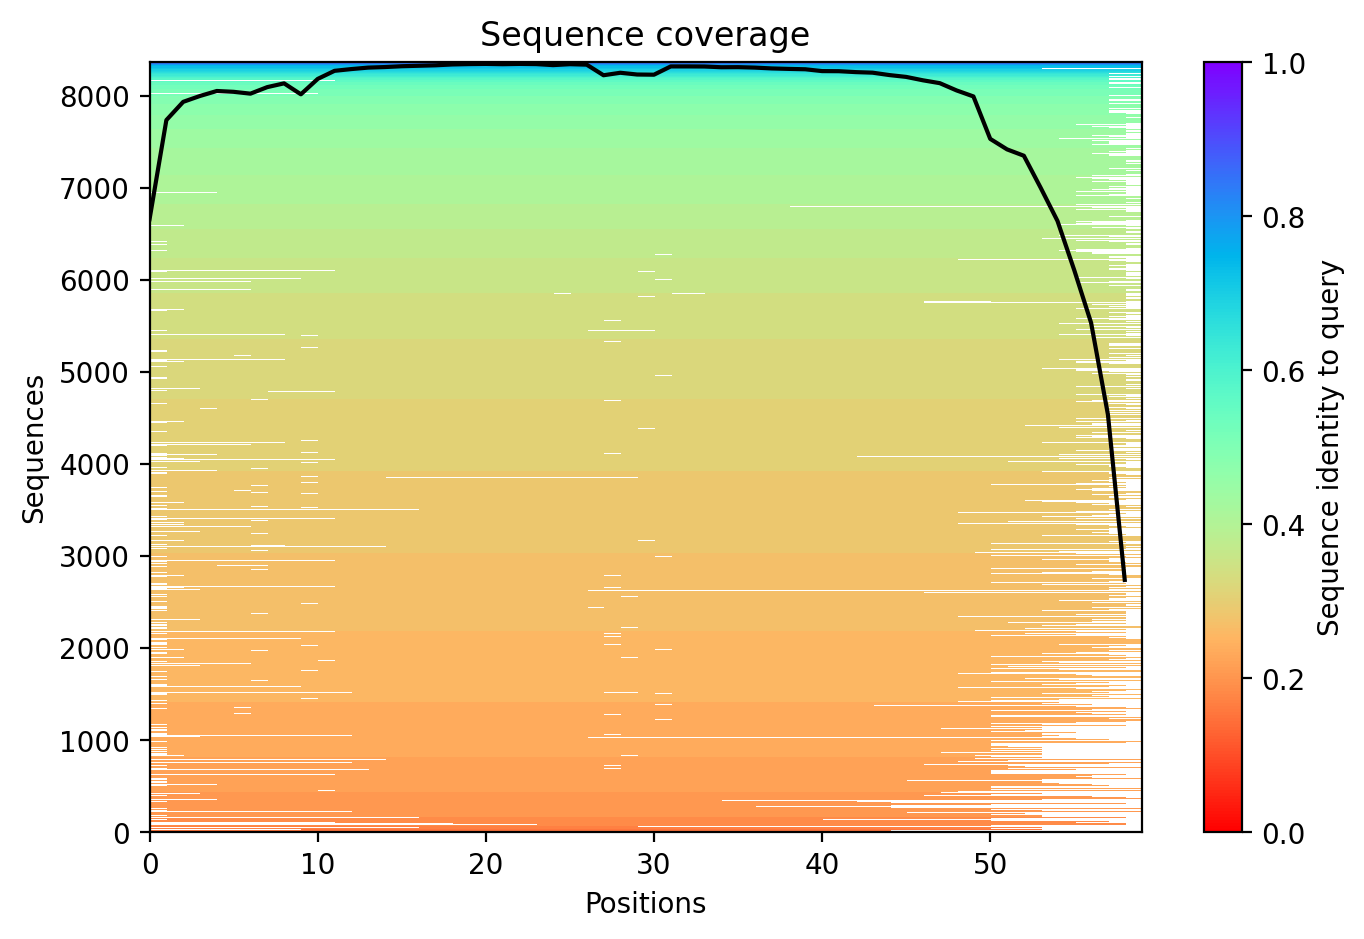
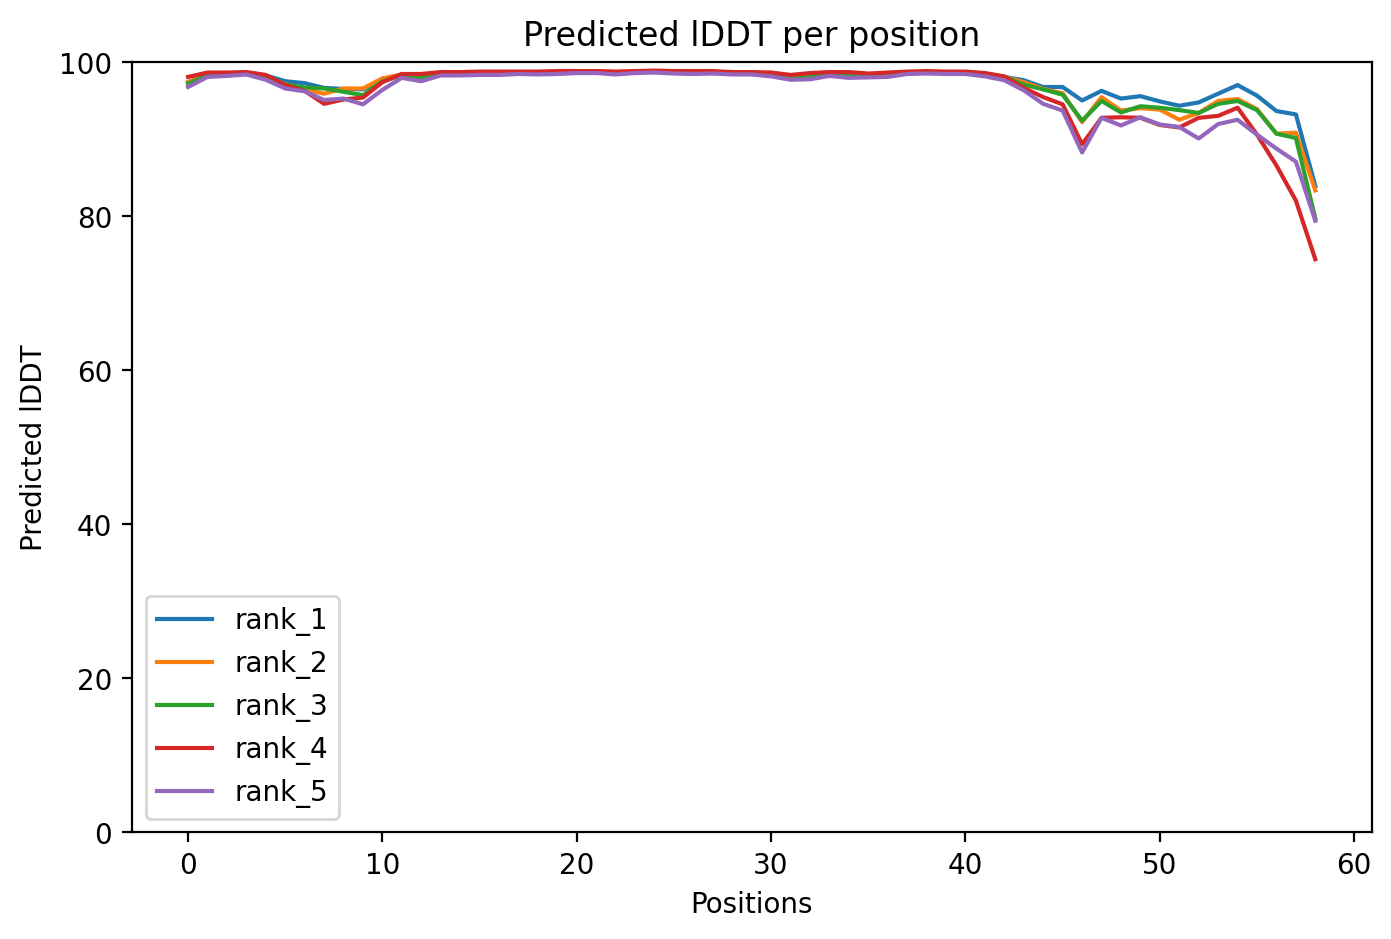

In [7]:
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

In [8]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>